## CHEME 5660: Using Single Index Models and Boltzmann Weighted Data in Markowitz Portfolio Allocation

### Introduction
Fill me in.

### Example setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-SIM-Boltzmann-Markowitz-notebook`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-SIM-Boltzmann-Markowitz-notebook/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-SIM-Boltzmann-Markowitz-notebook/Manifest.toml`


In [83]:
# load req packages -
using Convex
using SCS
using DataFrames
using Dates
using Colors
using Plots
using StatsPlots
using Statistics
using MathOptInterface
using FileIO
using JLD2
using PrettyTables
using Distributions
using LinearAlgebra

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1664


In [33]:
include("Example-SIM-Boltzmann-Markowitz-CodeLib.jl");

In [49]:
# daily risk-free rate -
r̄ = 0.0403;
risk_free_daily = ((1+r̄)^(1/365) - 1);

# how many days of historical data are we using?
m̂ = 596;

# step hist parameters -
number_of_bins = 80;

In [23]:
# load the JLD2 portfolio data file -
tmp = load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-10-30-22.jld2"))["dd"];

In [47]:
# how many elements do we have in SPY?
spy_df_length = length(tmp["SPY"][!,:close]);

# go through each of the tickers and *remove* tickers that don't have the same length as SPY -
price_data_dictionary = Dict{String, DataFrame}();
for (ticker, test_df) ∈ tmp
    
    # how long is test_df?
    test_df_length = length(test_df[!,:close])
    if (test_df_length == spy_df_length)
       price_data_dictionary[ticker] = test_df; 
    else
        println("Length violation: $(ticker) was removed; dim(SPY) = $(spy_df_length) days and dim($(ticker)) = $(test_df_length) days")
    end
end

Length violation: META was removed; dim(SPY) = 597 days and dim(META) = 247 days
Length violation: BIIB was removed; dim(SPY) = 597 days and dim(BIIB) = 596 days


In [166]:
# Compute (and visualize) same returns w and w/o weights -
ticker_to_explore = "MU"
λ̂ = 5e-3;
(R, R̂, W, μᵦ, pᵦ) = compute_excess_return(price_data_dictionary[ticker_to_explore]; m = m̂, rf = risk_free_daily, λ = λ̂);

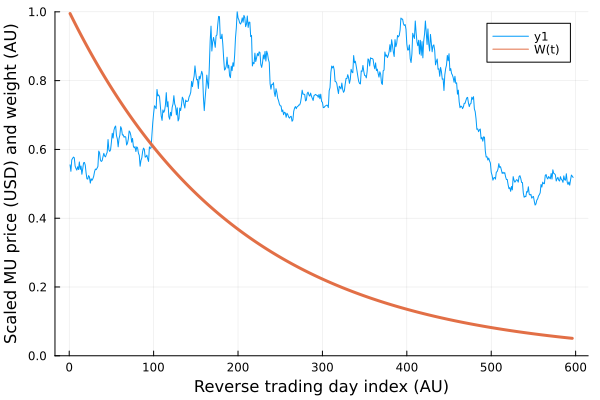

In [167]:
# grab data -
test_data = sort(price_data_dictionary[ticker_to_explore], [order(:timestamp, rev=true), :close]);

Sₒ = maximum(test_data[!, :close])
S = test_data[!, :close]

plot(S./Sₒ, ylim=(0.0,1.0))
plot!(W, lw=3, label="W(t)")

xlabel!("Reverse trading day index (AU)", fontsize=18)
ylabel!("Scaled $(ticker_to_explore) price (USD) and weight (AU)", fontsize=18)

In [164]:
println("mean R = $(mean(R)) and E(R̂) = $(μᵦ)")

mean R = 0.013403026122356096 and E(R̂) = -0.014615907561514254


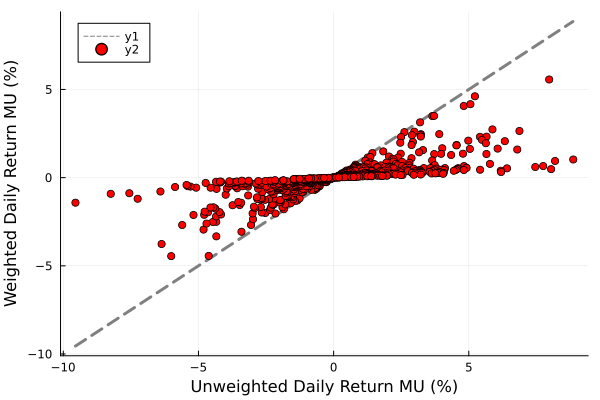

In [178]:
L = minimum(R);
U = maximum(R);

Z = range(L,stop=U,step=0.1) |> collect;
plot(Z,Z,lw=3, c=:gray, ls=:dash, legend=:topleft)
scatter!(R,R̂, c=:red)
xlabel!("Unweighted Daily Return $(ticker_to_explore) (%)", fontsize=18)
ylabel!("Weighted Daily Return $(ticker_to_explore) (%)", fontsize=18)

In [175]:
range(-L, stop=U, step=0.1)

9.54986338259674:0.1:9.44986338259674